In [195]:
import sys
sys.path.append('../')
import Yukawa_SINDy as ys
import numpy as np
import matplotlib.pyplot as plt
from pysindy.differentiation import FiniteDifference
from scipy.optimize import curve_fit

# ignore warnings generated from using LaTeX coding in matplotlib label strings
from warnings import filterwarnings
filterwarnings('ignore', message = 'invalid escape sequence')#,category=SyntaxWarning)

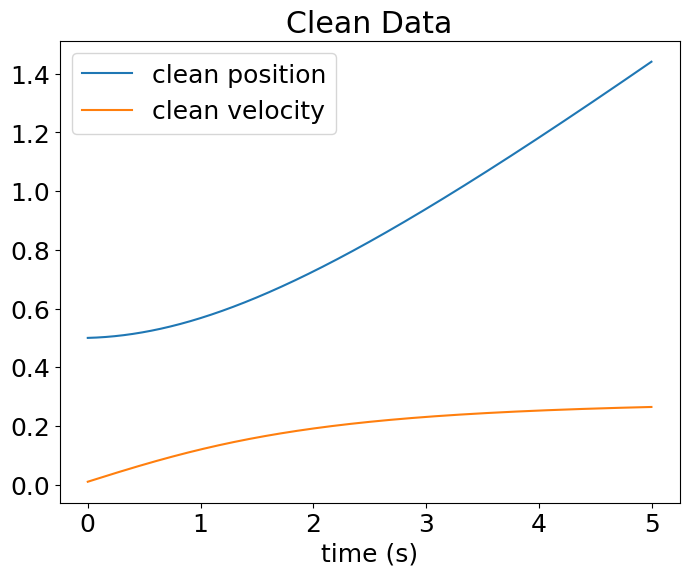

In [229]:
# generate data and show
sim  = ys.Yukawa_simulation()
sim.simulate(5,x0=0.5,v0=0.01,scaled=True)
sim.plot()

In [230]:
def plot_vel_comparison(true_vel, fd_vel, t):
    '''
    Desc: Creates 2 subplots showing the velocity calculated by 'solve_ivp' (the "true" velocity) and
    that calculated by the finite difference method, as well as the abs. value of the  difference 
    between them (the "abs. error").
    '''
    fig, axs = plt.subplots(1,2, sharex=True, figsize=(10,5))
    axs[0].plot(t, true_vel, lw = 2, label="True velocity")
    axs[0].plot(t, fd_vel, '--', label="FD velocity")
    axs[0].set_ylabel("velocity")
    axs[0].set_xlim((0,5))
    axs[0].legend()

    axs[1].plot(t, np.abs(true_vel - fd_vel))
    axs[1].set_ylabel("abs. error")

    fig.suptitle("Comparison of FD and true velocity vs. time")
    fig.supxlabel("time ($\omega_{pd}$)")
    fig.tight_layout()

    return fig, axs

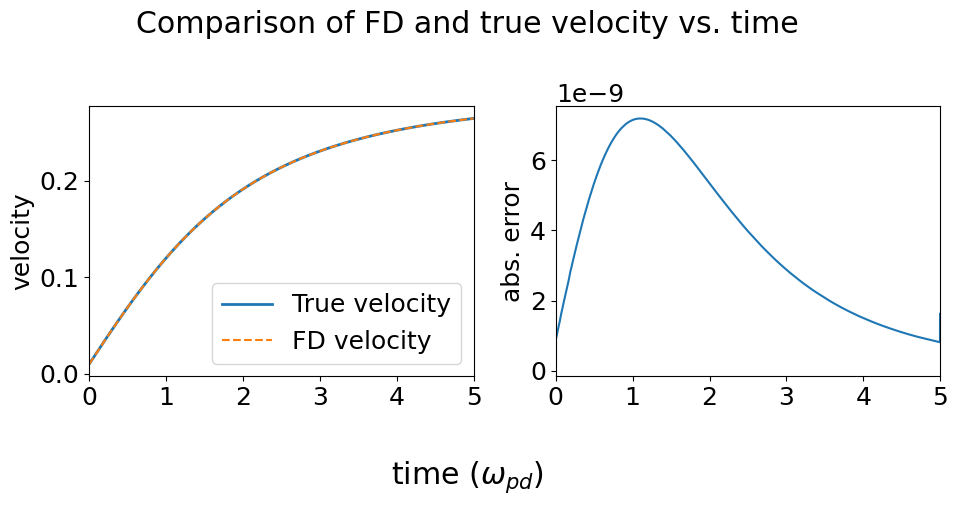

In [231]:
# calculate velocities from clean position data
vel_clean = sim.x[:,1]
fd = FiniteDifference()
vel_calc_clean = fd._differentiate(sim.x[:,0],sim.t)
fig, axs = plot_vel_comparison(vel_clean, vel_calc_clean, sim.t)

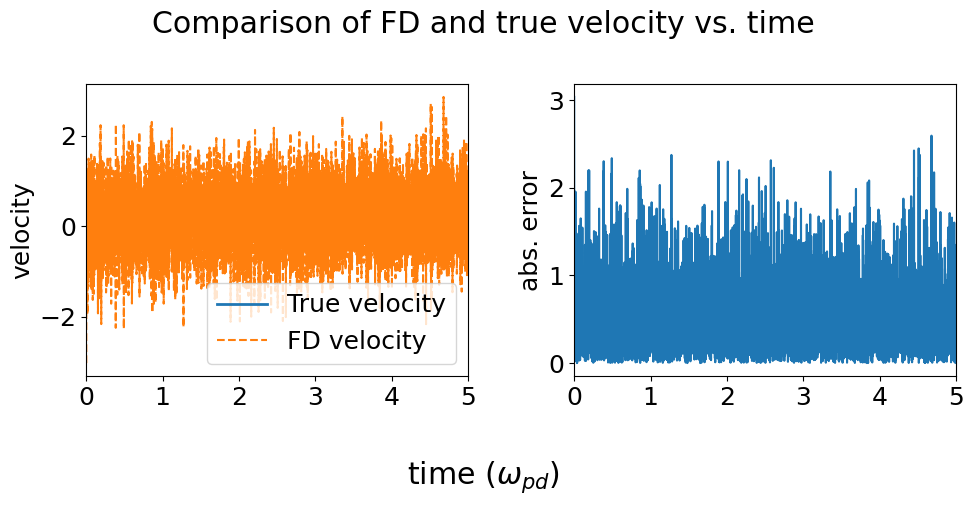

In [237]:
noise_level = 1e-3
if sim.is_noisy:
    sim.delete_noise()
sim.add_gaussian_noise(noise_level=noise_level)
vel_calc_001 = fd._differentiate(sim.x[:,0], sim.t)
fig, axs = plot_vel_comparison(vel_clean, vel_calc_001, sim.t)

In [238]:
def plot_noises(clean_pos, noisy_pos, clean_vel, noisy_vel, t):
    '''
    Desc: plot histograms of the error for position and velocity
    '''
    only_noise = np.zeros((clean_pos.shape[0],2))
    titles = np.empty((1,2), dtype="<U8")
    titles[0,0] = "position noise"
    only_noise[:,0] = noisy_pos - clean_pos
    titles[0,1] = "velocity noise"
    only_noise[:,1] = noisy_vel - clean_vel
    std_devs = only_noise.std(axis=0).round(5)
    sharex = True
    if std_devs[1]/std_devs[0] > 100:
        sharex = False
    # plot
    fig, axs = plt.subplots(1,2,figsize=(10,5), sharex=sharex)
    for i in range(2):
        axs[i].hist(only_noise[:,i])
        axs[i].set_title(titles[0,i])
        textstr = f"$\sigma={std_devs[i]}$"
        axs[i].text(0.05, 0.95, textstr, transform=axs[i].transAxes,
                    verticalalignment='top')
        axs[i].ticklabel_format(scilimits=(-3,5))
        axs[i].set_xlabel(titles[0,i] + " error")
    fig.supylabel("Counts")
    fig.tight_layout()
    
    return fig, axs


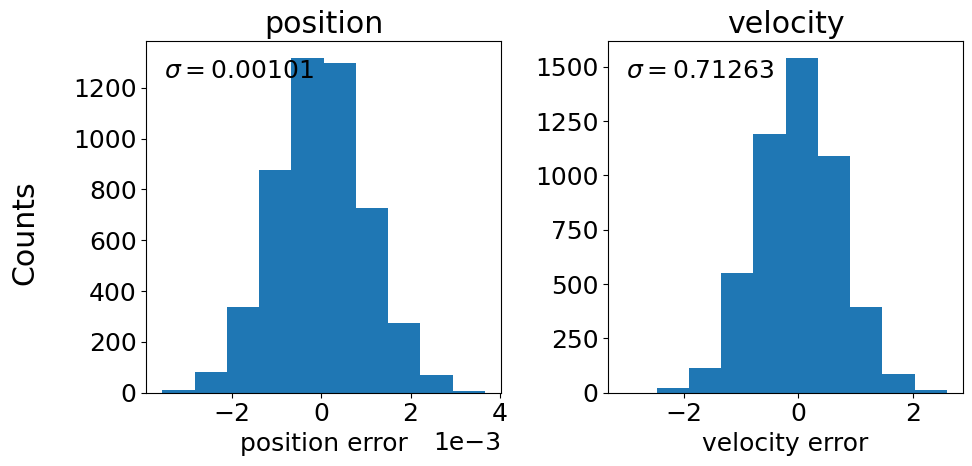

In [239]:
fig, axs = plot_noises(sim.x_clean[:,0], sim.x[:,0], vel_clean, vel_calc_001, sim.t)

In [235]:
def explore_std_devs(pos_std_dev_list):
    '''
    Desc:   finds standard deviation of error in velocity for a given 
            standard deviations in the position.
    '''
    sim = ys.Yukawa_simulation()
    sim.simulate(5)
    clean_position = sim.x[:,0]
    clean_velocity = sim.x[:,1]

    fd = FiniteDifference()

    position_data = np.zeros((sim.x.shape[0], len(pos_std_dev_list)))
    velocity_data = np.zeros_like(position_data)
    for i, std_dev in enumerate(pos_std_dev_list):
        if sim.is_noisy:
            sim.delete_noise()
        sim.add_gaussian_noise(std_dev)
        position_data[:, i] = sim.x[:,0]
        velocity_data[:, i] = fd._differentiate(sim.x[:,0], sim.t)
    only_noise_pos = position_data - clean_position.reshape(len(clean_position),1)
    pos_std_dev_calc = only_noise_pos.std(axis=0)
    only_noise_vel = velocity_data - clean_velocity.reshape(len(clean_velocity),1)
    vel_std_dev_calc = only_noise_vel.std(axis=0)
    return pos_std_dev_calc, vel_std_dev_calc

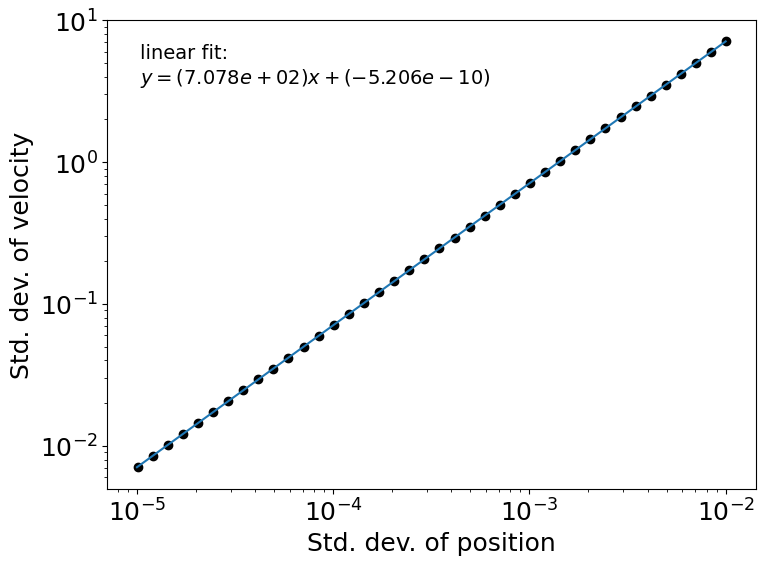

In [236]:
pos_std_in = np.logspace(-5,-2,num=40)
pos_std_out, vel_std = explore_std_devs(pos_std_in)
# linear curve fit
coef, _ = curve_fit(lambda x, m, b: m*x + b, pos_std_out, vel_std)
fity = coef[0]*pos_std_in + coef[1]
# plot
fig, ax = plt.subplots()
ax.loglog(pos_std_out, vel_std, 'ko')
ax.loglog(pos_std_in, fity, '-')
ax.set_xlabel("Std. dev. of position")
ax.set_ylabel("Std. dev. of velocity")
nice_coef = [np.format_float_scientific(x, 3) for x in coef]
fit_text = f"linear fit:\n$y=({nice_coef[0]})x+({nice_coef[1]})$"
ax.text(0.05, 0.95, fit_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
fig.tight_layout()